In [1]:
import mlflow

mlflow.set_tracking_uri("file:///C:/Users/Cristina/Desktop/projetoEngML/kobe-project/mlruns")

run_id = "bc2746509b1e4e7bb3064371d1a13071"
model_uri = f"runs:/{run_id}/modelo_logistico"
model_name = "predict"

mlflow.register_model(model_uri=model_uri, name=model_name)


Registered model 'predict' already exists. Creating a new version of this model...
Created version '5' of model 'predict'.


<ModelVersion: aliases=[], creation_timestamp=1743901113806, current_stage='None', description=None, last_updated_timestamp=1743901113806, name='predict', run_id='bc2746509b1e4e7bb3064371d1a13071', run_link=None, source='file:///C:/Users/Cristina/Desktop/projetoEngML/kobe-project/mlruns/0/bc2746509b1e4e7bb3064371d1a13071/artifacts/modelo_logistico', status='READY', status_message=None, tags={}, user_id=None, version=5>

In [2]:
import pandas as pd

# Carregar o arquivo enviado
df_dev = pd.read_parquet("../data/01_raw/dataset_kobe_dev.parquet")

# Verificar a distribuição da variável alvo
alvo_distribuicao = df_dev["shot_made_flag"].value_counts(dropna=False, normalize=True)

# Verificar valores únicos da coluna alvo
valores_unicos = df_dev["shot_made_flag"].unique()

# Quantidade de NaNs
qtd_nulos = df_dev["shot_made_flag"].isna().sum()

alvo_distribuicao, valores_unicos, qtd_nulos


(shot_made_flag
 0.0    0.436818
 1.0    0.398953
 NaN    0.164229
 Name: proportion, dtype: float64,
 array([nan,  0.,  1.]),
 3986)

In [3]:
import mlflow.sklearn
import pandas as pd
from sklearn.metrics import log_loss, f1_score

def aplicar_modelo_em_producao(
   path_modelo: str = "models:/KobeShotPrediction/latest",
    path_base_prod: str = "../data/01_raw/dataset_kobe_prod.parquet",
    salvar_resultado_em: str = "../data/08_reporting/previsoes_producao.parquet"
):
    with mlflow.start_run(run_name="PipelineAplicacao"):

        # 1) Carregar modelo
        modelo = mlflow.sklearn.load_model(path_modelo)

        # 2) Carregar base de produção
        df_prod = pd.read_parquet(path_base_prod)

        # 3) Selecionar colunas e remover NaNs
        colunas_esperadas = ["lat", "lon", "minutes_remaining", "period", "playoffs", "shot_distance", "shot_made_flag"]
        df_prod = df_prod.dropna(subset=colunas_esperadas)

        # 4) Separar X e y
        X = df_prod[colunas_esperadas[:-1]]  # todas menos o shot_made_flag
        y_true = df_prod["shot_made_flag"]

        # 5) Previsão
        y_proba = modelo.predict_proba(X)[:, 1]
        y_pred = modelo.predict(X)

        # 6) Salvar resultado
        df_prod["prediction_score"] = y_proba
        df_prod["prediction_label"] = y_pred
        df_prod.to_parquet(salvar_resultado_em, index=False)
        mlflow.log_artifact(salvar_resultado_em)

        # 7) Avaliar com métricas
        f1 = f1_score(y_true, y_pred)
        loss = log_loss(y_true, y_proba)

        mlflow.log_metric("f1_score_producao", f1)
        mlflow.log_metric("log_loss_producao", loss)

        print(f"✔️ Log Loss: {loss:.4f} | F1 Score: {f1:.4f}")
        print("✅ Aplicação finalizada com sucesso.")

if __name__ == "__main__":
    aplicar_modelo_em_producao()


c:\Users\Cristina\Documents\myproject\.venv\Lib\site-packages\mlflow\store\artifact\utils\models.py:32: FutureWarning: ``mlflow.tracking.client.MlflowClient.get_latest_versions`` is deprecated since 2.9.0. Model registry stages will be removed in a future major release. To learn more about the deprecation of model registry stages, see our migration guide here: https://mlflow.org/docs/2.12.2/model-registry.html#migrating-from-stages
  latest = client.get_latest_versions(name, None if stage is None else [stage])


✔️ Log Loss: 16.3371 | F1 Score: 0.3378
✅ Aplicação finalizada com sucesso.


C:\Users\Cristina\AppData\Local\Temp\ipykernel_23700\3701957491.py:28: UserWarning: Glyph 127936 (\N{BASKETBALL AND HOOP}) missing from current font.
  plt.tight_layout()
c:\Users\Cristina\Documents\myproject\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127936 (\N{BASKETBALL AND HOOP}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


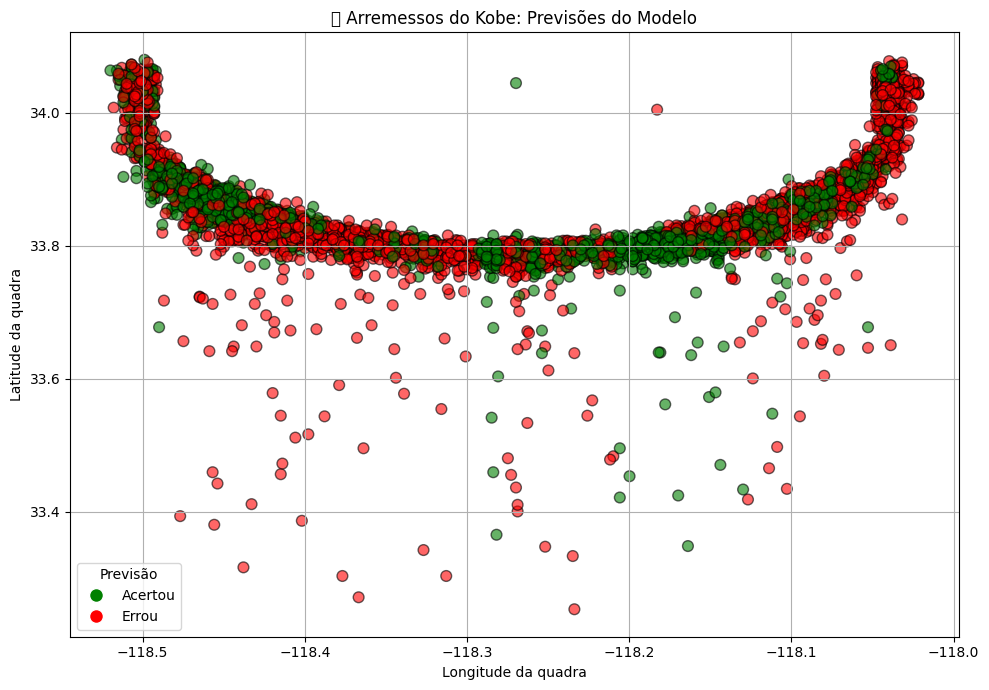

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

# Carregar a base com os resultados já aplicados
df_resultado = pd.read_parquet("../data/08_reporting/previsoes_producao.parquet")

# Verificar se há colunas necessárias
colunas_necessarias = {"lat", "lon", "prediction_label", "shot_made_flag"}
if not colunas_necessarias.issubset(df_resultado.columns):
    df_resultado.columns

# Criar gráfico
plt.figure(figsize=(10, 7))
cores = df_resultado["prediction_label"].map({1: "green", 0: "red"})

plt.scatter(df_resultado["lon"], df_resultado["lat"], 
            c=cores, alpha=0.6, edgecolor="k", s=60)

plt.title("🏀 Arremessos do Kobe: Previsões do Modelo")
plt.xlabel("Longitude da quadra")
plt.ylabel("Latitude da quadra")
plt.grid(True)
plt.legend(handles=[
    plt.Line2D([0], [0], marker='o', color='w', label='Acertou', markerfacecolor='green', markersize=10),
    plt.Line2D([0], [0], marker='o', color='w', label='Errou', markerfacecolor='red', markersize=10),
], title="Previsão")

plt.tight_layout()
plt.show()
